# Selección de características y últimos detalles sobre la tarjeta de datos
## Minería de datos - Grupo 2ASJ


## Librerías y herramientas


*Importamos* aquellas herramientas y librerías que hemos necesitado para poder trabajar en este cuaderno.

In [ ]:
# Data load and manipulation
from google.colab import files
import io
 
# DataFrame librery
import pandas as pd
 
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
 
# Basic Operations
import numpy as np
from numpy import corrcoef, transpose
import itertools
import operator
 
# Prepocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer


#Feature Selection
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_regression, SelectFromModel, SelectPercentile, SelectFpr
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

## Carga de la tarjeta de datos

Definimos un método para poder cargar los datos, y posteriormente cargamos la tarjeta de datos.

In [ ]:
def upload_files (index_fields = None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    if index_fields:
      df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    else:
      df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [ ]:
print("Por favor, sube el fichero 'tarjeta_datos.csv'")
tarjeta_datos = upload_files()
tarjeta_datos.head()

Por favor, sube el fichero 'tarjeta_datos.csv'


Saving tarjeta_datos.csv to tarjeta_datos.csv
User uploaded file "tarjeta_datos.csv" with length 171705949 bytes


,number_developer_games,avalaible_on_linux,avalaible_on_mac,avalaible_on_windows,required_age,Local Multi-Player,Stats,Cross-Platform Multiplayer,Full controller support,Captions available,Steam Cloud,Steam Leaderboards,Includes level editor,Steam Achievements,Steam Workshop,Online Multi-Player,Online Co-op,MMO,Shared/Split Screen,Multi-player,Steam Trading Cards,Local Co-op,Co-op,Partial Controller Support,In-App Purchases,Casual,Massively Multiplayer,Sexual Content,Gore,Racing,RPG,Adventure,Violent,Free to Play,Early Access,Action,Indie,Sports,Strategy,Simulation,...,zone,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WRB,num_palabras,num_oraciones,negative,positive,neutral,compound
0,26.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049722,0.0,0.0,0.000000,0.0,0.340236,0.0,0.0,0.000000,0.927666,0.000000,0.0,0.0,0.0,0.0,0.0,0.136959,0.0,0.0,0.0,0.0,0.0,0.0,0.049461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,58,7,0.197,0.361,0.442,0.7867
1,26.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.084791,0.0,0.0,0.000000,0.0,0.217577,0.0,0.0,0.000000,0.970744,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.039645,0.000000,0.000000,0.039432,0.0,0.0,0.0,0.0,63,2,0.100,0.171,0.729,0.4767
2,26.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.429065,0.0,0.0,0.080876,0.889482,0.055853,0.0,0.0,0.0,0.0,0.0,0.041871,0.0,0.0,0.0,0.0,0.0,0.0,0.045363,0.042644,0.000000,0.097134,0.000000,0.0,0.0,0.0,0.0,73,4,0.194,0.085,0.722,-0.7430
3,26.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.179714,0.0,0.178032,0.0,0.0,0.000000,0.941400,0.169949,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.129757,0.063664,0.000000,0.000000,0.0,0.0,0.0,0.0,45,3,0.000,0.173,0.827,0.5859
4,7.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.058139,0.0,0.0,0.000000,0.0,0.596748,0.0,0.0,0.000000,0.788875,0.000000,0.0,0.0,0.0,0.0,0.0,0.106762,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.054367,0.000000,0.061918,0.000000,0.0,0.0,0.0,0.0,55,4,0.053,0.076,0.871,0.2023


## División de la tarjeta de datos - Features y target

Para poder trabajar comodamente con los datos, tanto en este cuaderno como a la hora de aplicar los diferentes algoritmos, vamos a dividir la tarjeta de datos en dos conjuntos de datos diferentes. Estos conjuntos de datos son los siguientes:

- El conjunto de datos X que contendrá las características que utilizaremos como entrada para los diferentes modelos.
- El conjunto de datos y, que contendrá únicamente nuestro target o valor a predecir.

In [ ]:
X = tarjeta_datos.drop(['target_x'], axis=1)
y = tarjeta_datos['target_x']

## Selección de características


Antes de lidiar con los algoritmos, tenemos que solucionar un gran inconveniente de nuestra tarjeta de datos, la gran dimensionalidad de esta. Para reducir la dimensionalidad de la tarjeta de datos, se va a llevar a cabo una selección de característica, con la finalidad de reducir las características de nuestra tarjeta de datos en un gran porcentaje.

Este proceso se va a dividir en dos partes, una selección de características sencilla sobre las características provenientes de las descripciones de los juegos y de las SteamSpy Tags, y una selección de características más manual sobre el resto de características. Al hacer este proceso en dos partes, vamos a necesitar dividir nuestro conjunto de datos X en otros tres conjuntos de datos. 

In [ ]:
X_featureselec_1 = X[X.columns[:47]].copy()     # Otras características
X_featureselec_2 = X[X.columns[47:418]].copy()  # SteamSpy Tags
X_featureselec_3 = X[X.columns[418:]].copy()    # NLP Features

Por un lado, primero trabajaremos con las características relacionadas con las descripciones de los juegos y las SteamSpy Tags, y por el otro, trabajaremos con el resto de características.

### Características relacionadas con las descripciones de los juegos (NLP) y con las SteamSpy Tags

Una vez tenemos divido el conjunto de datos principal debido a su gran dimensionalidad, podemos empezar a trabajar en la selección de características por seperada de cada subconjunto de datos.

En el caso de las características correspondientes a las descripciones de los juegos y las SteamSpy Tags, la selección de características se llevará a cabo gracias a los algoritmos para este cometido que ofrece el módulo *feature_selection* de la librería *sklearn*.

In [ ]:
features_spy = len(list(X_featureselec_2))
features_nlp = len(list(X_featureselec_3))

print("Features SteamSpy Tags: " + str(features_spy))
print("Features NLP: " + str(features_nlp))

Features SteamSpy Tags: 371
Features NLP: 1801


Lo que se detectó al crear la tarjeta de datos, es que muchos valores de las SteamSpy Tags ya estaban repetidos en en las features de NLP, por tanto esto indica que las palabras de las descripciones podrían representar la misma información que las etiquetas.

Por tanto, vamos a ver cuantos valores coincidentes hay.

In [ ]:
contador = 0
for item in X_featureselec_2.columns:
  if item[len(item)-2:] == '_x':
    contador+=1
print("Coinciden en {} features".format(contador))

Coinciden en 90 features


Prácticamente, un cuarto de la información ya estaba recogida con el procesamiento de la descripción.

In [ ]:
X_featureselec_2.head()

,1980s,1990s,2.5d,2d_x,2d_fighter,360_video,3d_x,3d_platformer,3d_vision,4_player_local,4x,6dof,atv,abstract,action_x,action_rpg,action_adventure,addictive_x,adventure_x,agriculture,aliens,alternate_history,america_x,animation_&_modeling,anime,arcade_x,arena_shooter,artificial_intelligence,assassin,asynchronous_multiplayer,atmospheric_x,audio_production,bmx,base_building,baseball,based_on_a_novel,basketball,batman,battle_royale,beat_em_up,...,touch_friendly,tower_defense,trackir,trading_x,trading_card_game,trains,transhumanism,turn_based,turn_based_combat,turn_based_strategy,turn_based_tactics,tutorial_x,twin_stick_shooter,typing,underground_x,underwater,unforgiving,utilities,vr_x,vr_only,vampire,video_production,villain_protagonist,violent,visual_novel,voice_control,voxel,walking_simulator,war_x,wargame,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,0.009231,0.036156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171870,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00968,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002564,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.035259
1,0.000000,0.043425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127217,0.0,0.0,0.0,0.009174,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015902,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100202,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.080972,0.0,0.0,0.0,0.0,0.0,0.0,0.005061,0.123482,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221354,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.057292,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,0.000000,0.043307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.118673,0.0,0.0,0.0,0.048931,0.0,0.068616,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.041057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [ ]:
X_featureselec_3.head()

,2d_y,360,3d_y,50,60,70,80,90,abandoned,ability,able,access,accessible,acclaimed,according,account,accurate,achieve,achievement,acquire,across,act,acting,action_y,actionpacked,active,activity,actual,actually,adapt,add,added,addictive_y,adding,addition,additional,adjust,advance,advanced,advantage,...,zone,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WRB,num_palabras,num_oraciones,negative,positive,neutral,compound
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049722,0.0,0.0,0.000000,0.0,0.340236,0.0,0.0,0.000000,0.927666,0.000000,0.0,0.0,0.0,0.0,0.0,0.136959,0.0,0.0,0.0,0.0,0.0,0.0,0.049461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,58,7,0.197,0.361,0.442,0.7867
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.084791,0.0,0.0,0.000000,0.0,0.217577,0.0,0.0,0.000000,0.970744,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.039645,0.000000,0.000000,0.039432,0.0,0.0,0.0,0.0,63,2,0.100,0.171,0.729,0.4767
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.429065,0.0,0.0,0.080876,0.889482,0.055853,0.0,0.0,0.0,0.0,0.0,0.041871,0.0,0.0,0.0,0.0,0.0,0.0,0.045363,0.042644,0.000000,0.097134,0.000000,0.0,0.0,0.0,0.0,73,4,0.194,0.085,0.722,-0.7430
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.179714,0.0,0.178032,0.0,0.0,0.000000,0.941400,0.169949,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.129757,0.063664,0.000000,0.000000,0.0,0.0,0.0,0.0,45,3,0.000,0.173,0.827,0.5859
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.058139,0.0,0.0,0.000000,0.0,0.596748,0.0,0.0,0.000000,0.788875,0.000000,0.0,0.0,0.0,0.0,0.0,0.106762,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.054367,0.000000,0.061918,0.000000,0.0,0.0,0.0,0.0,55,4,0.053,0.076,0.871,0.2023


Viendo las features de este dataset, detectamos que las features representan prácticamente lo mismo, un valor de pertenencia entre 0 y 1. Un ejemplo claro sería action (action_x en las etiquetas, action_y en las descripciones). Dichas features tiene valores prácticamente similares, aunque en algunos juegos dependiendo del dataset no se encuentre ningún valor. Por tanto, creemos que lo mejor sería hacer la media de los valores repetidos, y unir al dataset de las descripciones las demás etiquetas.

In [ ]:
for item in X_featureselec_2.columns:
  if item[len(item)-2:] == '_x':
    X_featureselec_3["{}_y".format(item[:len(item)-2])] = (X_featureselec_2[item] + X_featureselec_3["{}_y".format(item[:len(item)-2])])/2
    X_featureselec_3 = X_featureselec_3.rename(columns={"{}_y".format(item[len(item)-2:]):item[len(item)-2:]})
  else:
    X_featureselec_3[item] = X_featureselec_2[item]

Una vez que ya se tienen todos los valores en el mismo dataset, procedemos a hacer la selección de características. 

Para ello, utilizaremos el método SelectKBest, ya que queremos obtener las 100 mejores features de todas las del dataset. Este método permite escoger los mejores K features de un dataset.

In [ ]:
selector = SelectKBest(score_func = mutual_info_regression, k = 200)

features_seleccionadas = selector.fit_transform(X_featureselec_3, y)
print(features_seleccionadas.shape)

selected = selector.get_support(indices=True)
selected

Las features escogidas son las siguientes:

In [ ]:
features_names = np.asarray(X_featureselec_3.columns)[selector.get_support()]
features_names

Guardamos todo en un dataset, y lo exportamos para tener la información más a mano.

In [ ]:
descripciones_selected_features = pd.DataFrame(features_seleccionadas,columns=features_names)
descripciones_selected_features

### El resto de las características

Cómo hemos visto anteriormente, vamos a hacer una selección de características más manual sobre el resto de características de nuestro dataset, como por ejemplo el precio, los géneros o el número de juegos desarrollados por la compañía.

Este conjunto está compuesto por 47 características, como por ejemplo las que se pueden ver en la siguiente celda.

In [ ]:
features = len(list(X_featureselec_1))
print("Resto de features: " + str(features))
print(list(X_featureselec_1.columns))

Resto de features: 47
['number_developer_games', 'avalaible_on_linux', 'avalaible_on_mac', 'avalaible_on_windows', 'required_age', 'Local Multi-Player', 'Stats', 'Cross-Platform Multiplayer', 'Full controller support', 'Captions available', 'Steam Cloud', 'Steam Leaderboards', 'Includes level editor', 'Steam Achievements', 'Steam Workshop', 'Online Multi-Player', 'Online Co-op', 'MMO', 'Shared/Split Screen', 'Multi-player', 'Steam Trading Cards', 'Local Co-op', 'Co-op', 'Partial Controller Support', 'In-App Purchases', 'Casual', 'Massively Multiplayer', 'Sexual Content', 'Gore', 'Racing', 'RPG', 'Adventure', 'Violent', 'Free to Play', 'Early Access', 'Action', 'Indie', 'Sports', 'Strategy', 'Simulation', 'Nudity', 'achievements', 'average_playtime', 'median_playtime', 'owners', 'price_x', 'RAM']


Lo primero que hemos hecho ha sido descargarnos este conjunto de datos con las características restantes, y crear un árbol de decisión sencillo en BigML que nos permita ver la importancia de dichas características. Nos basaremos en estas importancias más adelante para tomar decisiones.

Dicha importancia de características la podemos ver tanto en la imágen siguiente (En la que únicamente se muestran las 10 características más importantes), como en el diccionario de la próxima celda (En el que aparecen las 24 características consideradas por el árbol de decisión).

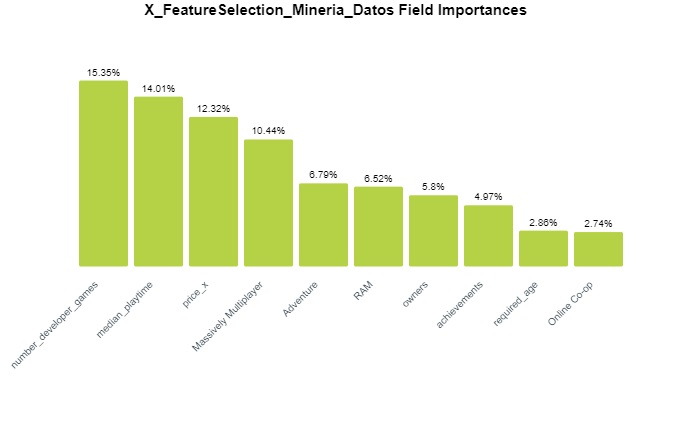

In [ ]:
relevance_dict = {
  "000000": {
    "name": "number_developer_games",
    "importance": 0.15347
  },
  "00002b": {
    "name": "median_playtime",
    "importance": 0.14008
  },
  "00002d": {
    "name": "price_x",
    "importance": 0.12319
  },
  "00001a": {
    "name": "Massively Multiplayer",
    "importance": 0.10444
  },
  "00001f": {
    "name": "Adventure",
    "importance": 0.06794
  },
  "00002e": {
    "name": "RAM",
    "importance": 0.0652
  },
  "00002c": {
    "name": "owners",
    "importance": 0.05802
  },
  "000029": {
    "name": "achievements",
    "importance": 0.04968
  },
  "000004": {
    "name": "required_age",
    "importance": 0.02859
  },
  "000010": {
    "name": "Online Co-op",
    "importance": 0.02741
  },
  "00002a": {
    "name": "average_playtime",
    "importance": 0.02539
  },
  "00001c": {
    "name": "Gore",
    "importance": 0.02343
  },
  "000027": {
    "name": "Simulation",
    "importance": 0.02046
  },
  "000023": {
    "name": "Action",
    "importance": 0.01507
  },
  "000007": {
    "name": "Cross-Platform Multiplayer",
    "importance": 0.01429
  },
  "00000f": {
    "name": "Online Multi-Player",
    "importance": 0.01325
  },
  "000016": {
    "name": "Co-op",
    "importance": 0.01304
  },
  "000026": {
    "name": "Strategy",
    "importance": 0.01202
  },
  "000024": {
    "name": "Indie",
    "importance": 0.00999
  },
  "00000d": {
    "name": "Steam Achievements",
    "importance": 0.00888
  },
  "00001b": {
    "name": "Sexual Content",
    "importance": 0.00799
  },
  "000025": {
    "name": "Sports",
    "importance": 0.00765
  },
  "000008": {
    "name": "Full controller support",
    "importance": 0.00561
  },
  "000014": {
    "name": "Steam Trading Cards",
    "importance": 0.0049
  }
}

Con el fin de obtener un poco más de información que nos permita realizar esta selección de característica, hemos calculado y mostrado la matriz de correlación entre estas características.

In [ ]:
transposed_df = transpose(X_featureselec_1)
names = transposed_df.index.values
transposed_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16767,16768,16769,16770,16771,16772,16773,16774,16775,16776,16777,16778,16779,16780,16781,16782,16783,16784,16785,16786,16787,16788,16789,16790,16791,16792,16793,16794,16795,16796,16797,16798,16799,16800,16801,16802,16803,16804,16805,16806
number_developer_games,26.0,26.0,26.0,26.0,7.0,26.0,26.0,26.0,7.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,1.0,1.0,5.0,5.0,3.0,7.0,7.0,7.0,7.0,4.0,2.0,5.0,5.0,5.0,2.0,...,2.0,9.0,2.0,2.0,1.0,1.0,1.0,1.0,5.0,2.0,10.0,1.0,1.0,3.0,1.0,12.0,1.0,1.0,2.0,1.0,4.0,2.0,1.0,1.0,10.0,2.0,3.0,1.0,1.0,3.0,3.0,1.0,1.0,5.0,2.0,4.0,3.0,1.0,1.0,2.0
avalaible_on_linux,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
avalaible_on_mac,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
avalaible_on_windows,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
required_age,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


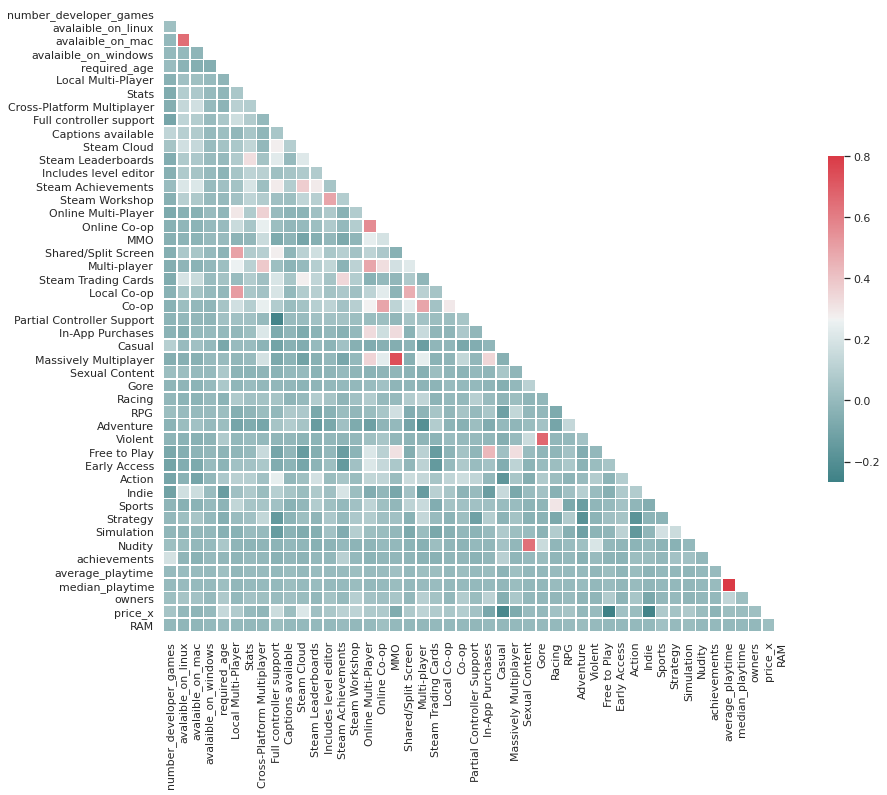

In [ ]:
R = corrcoef(transposed_df)

# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

En esta matriz, podemos ver que hay algunas características bastante correlacionadas entre sí, como por ejemplo 'Massively Multiplayer' y 'MMO', o 'Violent' y 'Gore'. Al igual que con la importancia, utilizaremos esta información posteriormente para sacar conclusiones.

Por último, para esta selección de características 'manual', vamos a calcular la correlación de cada una de las características con la variable objetivo.

In [ ]:
# Añadimos una columna con el target al resto de características para ver la correlación de estas características con dicho target
corr_df = X_featureselec_1.copy()
corr_df['target'] = y

# Mostramos la correlación de cada una de las características con el target
corr_df[corr_df.columns].corr()['target'][:-1]

number_developer_games       -0.047796
avalaible_on_linux            0.146062
avalaible_on_mac              0.156392
avalaible_on_windows          0.005439
required_age                  0.018868
Local Multi-Player            0.049439
Stats                         0.039685
Cross-Platform Multiplayer   -0.013353
Full controller support       0.156655
Captions available            0.048520
Steam Cloud                   0.224865
Steam Leaderboards            0.109157
Includes level editor         0.061519
Steam Achievements            0.173744
Steam Workshop                0.071247
Online Multi-Player          -0.036011
Online Co-op                 -0.015527
MMO                          -0.091593
Shared/Split Screen           0.061170
Multi-player                 -0.054187
Steam Trading Cards           0.055547
Local Co-op                   0.068143
Co-op                        -0.000992
Partial Controller Support    0.006831
In-App Purchases             -0.090453
Casual                   

Como vemos, no hay ninguna característica que tenga correlación con la variable objetivo, por lo que esto no nos va a aportar mucha información que nos permita sacar conclusiones para la selección de características.

**Conclusiones**

Para realizar esta selección de características hemos considerado que lo mejor va a ser seleccionar únicamente aquellas características que ha tomado en consideración el árbol de decisión probado en BigML. Estas características se van a extraer del diccionario exportado desde el propio BigML que hemos declarado antes.

Entre estas características, encontramos algunas que tienen un alto grado de correlación entre ellas, aportándonos cierta información redundante. En este caso, desecharemos aquella característica de ambas que menor grado de importancia tenga. Por ejemplo, 'average_playtime' y 'median_playtime' aparecen entre las características con más importancia, pero entre ellas tienen un grado de correlación bastante alto, por lo que desecharemos 'average_playtime' ya que tiene menor grado de importancia que 'median_playtime'

In [ ]:
# Obtenemos las características relevantes del diccionario
relevance_cols = []
for k in relevance_dict.keys():
  relevance_cols.append(relevance_dict[k]["name"])

print("Número de características relevantes: " + str(len(relevance_cols)))

# Como entre estas características aparecen 'median_playtime' y 'average_playtime', y estas tienen una gran correlación entre ella, nos quedamos unicamente con aquella que tenga más relevancia
relevance_playtime = {}
for k in relevance_dict.keys():
  if (relevance_dict[k]["name"] == 'median_playtime') or (relevance_dict[k]["name"] == 'average_playtime'):
    relevance_playtime[relevance_dict[k]["name"]] = relevance_dict[k]["importance"]

if relevance_playtime["median_playtime"] > relevance_playtime["average_playtime"]:
  relevance_cols.remove("average_playtime")
else:
  relevance_cols.remove("median_playtime")

print("Características finales: " + str(relevance_cols))

Número de características relevantes: 24
Características finales: ['number_developer_games', 'median_playtime', 'price_x', 'Massively Multiplayer', 'Adventure', 'RAM', 'owners', 'achievements', 'required_age', 'Online Co-op', 'Gore', 'Simulation', 'Action', 'Cross-Platform Multiplayer', 'Online Multi-Player', 'Co-op', 'Strategy', 'Indie', 'Steam Achievements', 'Sexual Content', 'Sports', 'Full controller support', 'Steam Trading Cards']


Por último, filtramos el conjunto de datos por estas columnas. 

In [ ]:
other_features_selected_features = X_featureselec_1[relevance_cols]

Tras hacer la selección de características, tenemos que volver a concatenar los resultados para obtener el nuevo conjunto de datos X con las características reducidas que utilizaremos como entrada para los diferentes modelos.

In [ ]:
X = pd.merge(other_features_selected_features, descripciones_selected_features, left_index=True, right_index=True)
X

,number_developer_games,median_playtime,price_x,Massively Multiplayer,Adventure,RAM,owners,achievements,required_age,Online Co-op,Gore,Simulation,Action,Cross-Platform Multiplayer,Online Multi-Player,Co-op,Strategy,Indie,Steam Achievements,Sexual Content,Sports,Full controller support,Steam Trading Cards,2d_y,access,action_y,adventure_y,ammo,animation,anyone,arcade_y,armor,array,art,atmospheric_y,awardwinning,battle,beautiful_y,become,blend,...,RB,VB,num_oraciones,negative,positive,1990s,anime,base_building,co_op,comedy,dark_fantasy,female_protagonist,first_person,free_to_play,gore,great_soundtrack,hand_drawn,interactive_fiction,isometric,local_co_op,local_multiplayer,moba,massively_multiplayer,mature,metroidvania,minimalist,moddable,open_world,pixel_graphics,robots,rogue_like,rogue_lite,sci_fi,sexual_content,shoot_em_up,side_scroller,story_rich,typing,vr_only,visual_novel
0,26.0,317.0,7.19,0.0,0.0,96.0,15000000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.142707,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.136959,0.049461,7.0,0.197,0.361,0.036156,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.051221,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,26.0,62.0,3.99,0.0,0.0,96.0,7500000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.127198,0.004587,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,2.0,0.100,0.171,0.043425,0.00000,0.0,0.037920,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,26.0,34.0,3.99,0.0,0.0,96.0,7500000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.050101,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.041871,0.045363,4.0,0.194,0.085,0.000000,0.00000,0.0,0.012146,0.0,0.000000,0.000000,0.050607,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,26.0,184.0,3.99,0.0,0.0,96.0,7500000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.110677,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,3.0,0.000,0.173,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.085938,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.041667,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,7.0,415.0,3.99,0.0,0.0,96.0,7500000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.125149,0.024466,0.0,0.0,0.0,0.0,0.000000,0.0,0.166767,0.020529,0.0,0.000000,0.0,0.0,0.0,...,0.106762,0.000000,4.0,0.053,0.076,0.043307,0.00000,0.0,0.015186,0.0,0.000000,0.000000,0.070866,0.000000,0.010124,0.014061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008999,0.0,0.000000,0.0,0.000000,0.000000,0.093363,0.000000,0.0,0.000000,0.022497,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16802,4.0,0.0,0.00,0.0,1.0,1000.0,10000.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.026882,0.000000,0.036290,0.033602,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.066920,0.036251,8.0,0.112,0.220,0.000000,0.05914,0.0,0.000000,0.0,0.000000,0.053763,0.000000,0.099462,0.000000,0.043011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000

Por último, antes de continuar con la normalización y el resto de pasos, exportamos esta tarjeta de datos filtrada por aquellas características seleccionadas. Hacemos esto debido a que el proceso de selección de características es costoso, y de cara a probar diferentes scalers en el futuro podría llevarnos demasiado tiempo ejecutarlo todo.

In [ ]:
with open('X_no_normalized.csv', 'w') as f:
  X.to_csv(f,  index = False)

files.download('X_no_normalized.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X = pd.read_csv('./X_no_normalized.csv')

## Normalización

Antes de introducir nuestros datos en algún algoritmo, vamos a normalizarlos utilizando un scaler. Para esta normalización hemos probado diferentes scalers, quedándonos unicamente con el que mejor resultados nos ha dado.

In [ ]:
# Definimos el scaler: MinMaxScaler, StandardScaler, RobustScaler....
scaler = MinMaxScaler()

# Adecuamos el scaler a los datos y realizamos la transformación sobre estos
X = pd.DataFrame(data = scaler.fit_transform(X), columns=X.columns)
X.head()

,number_developer_games,median_playtime,price_x,Massively Multiplayer,Adventure,RAM,owners,achievements,required_age,Online Co-op,Gore,Simulation,Action,Cross-Platform Multiplayer,Online Multi-Player,Co-op,Strategy,Indie,Steam Achievements,Sexual Content,Sports,Full controller support,Steam Trading Cards,2d_y,access,action_y,adventure_y,ammo,animation,anyone,arcade_y,armor,array,art,atmospheric_y,awardwinning,battle,beautiful_y,become,blend,...,RB,VB,num_oraciones,negative,positive,1990s,anime,base_building,co_op,comedy,dark_fantasy,female_protagonist,first_person,free_to_play,gore,great_soundtrack,hand_drawn,interactive_fiction,isometric,local_co_op,local_multiplayer,moba,massively_multiplayer,mature,metroidvania,minimalist,moddable,open_world,pixel_graphics,robots,rogue_like,rogue_lite,sci_fi,sexual_content,shoot_em_up,side_scroller,story_rich,typing,vr_only,visual_novel
0,0.268817,0.001663,0.034240,0.0,0.0,0.000048,0.099940,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263845,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.136959,0.057819,0.024561,0.24625,0.361,0.116161,0.0,0.0,0.000000,0.0,0.0,0.0,0.163268,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.268817,0.000325,0.019001,0.0,0.0,0.000048,0.049937,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235170,0.007639,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.007018,0.12500,0.171,0.139515,0.0,0.0,0.185389,0.0,0.0,0.0,0.212500,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.268817,0.000178,0.019001,0.0,0.0,0.000048,0.049937,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092630,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.041871,0.053029,0.014035,0.24250,0.085,0.000000,0.0,0.0,0.059379,0.0,0.0,0.0,0.161311,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.268817,0.000965,0.019001,0.0,0.0,0.000048,0.049937,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204626,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.010526,0.00000,0.173,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.273926,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.128827,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.064516,0.002177,0.019001,0.0,0.0,0.000048,0.049937,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.231382,0.040744,0.0,0.0,0.0,0.0,0.0,0.0,0.315351,0.077184,0.0,0.0,0.0,0.0,0.0,...,0.106762,0.000000,0.014035,0.06625,0.076,0.139136,0.0,0.0,0.074241,0.0,0.0,0.0,0.225886,0.0,0.027132,0.058057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063635,0.0,0.0,0.0,0.0,0.0,0.288664,0.0,0.0,0.0,0.072683,0.0,0.0,0.0


## División de la tarjeta de datos - Conjunto de entrenamiento y de test

Por último, dividimos nuestros conjuntos de datos X e y, en más conjuntos de datos correspondientes a aquellos que se van a utilizar para el entrenamiento y aquellos que se van a utilizar para el test.

In [ ]:
def split_train_test_customized(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  with open('X_train.csv', 'w') as f:
    X_train.to_csv('X_train.csv', index = False)
  
  with open('X_test.csv', 'w') as f:
    X_test.to_csv('X_test.csv', index = False)
  
  with open('y_train.csv', 'w') as f:
    y_train.to_csv('y_train.csv', index = False)
  
  with open('y_test.csv', 'w') as f:
    y_test.to_csv('y_test.csv', index = False)

  files.download('X_train.csv')
  files.download('X_test.csv')
  files.download('y_train.csv')
  files.download('y_test.csv')

split_train_test_customized(X, y, 0.33)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Otras pruebas


Por último en este cuaderno, vamos a exportar de nuevo todo, pero modificando el target para que sea categórico. De esta forma, podremos hacer pruebas con algoritmos de clasificación, sin tener que ceñirnos unicamente a regresión.

In [ ]:
def asignarClase(valor):
  clase = ""
  if valor >= 0.9:
    clase = 3 #"Overhwelmingly Positive"
  elif valor >= 0.8:
    clase = 2 #"Very Positive"
  elif valor >= 0.6:
    clase = 1 #"Positive"
  else:
    clase = 0 #"Negative"

  return clase

y = y.apply(asignarClase)
y.value_counts()

1    5741
2    4099
0    3655
3    3312
Name: target_x, dtype: int64

Volvemos a hacer el split en test y train para el target categórico.

In [ ]:
split_train_test_customized(X, y, 0.33)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>